In [2]:
bc_data <- read.table("data/breast-cancer-wisconsin.data.txt", 
                      header = FALSE, 
                      sep = ",")
colnames(bc_data) <- c("sample_code_number", 
                       "clump_thickness", 
                       "uniformity_of_cell_size", 
                       "uniformity_of_cell_shape", 
                       "marginal_adhesion", 
                       "single_epithelial_cell_size", 
                       "bare_nuclei", 
                       "bland_chromatin", 
                       "normal_nucleoli", 
                       "mitosis", 
                       "classes")

bc_data$classes <- ifelse(bc_data$classes == "2", "benign",
                          ifelse(bc_data$classes == "4", "malignant", NA))

In [3]:
bc_data[bc_data == "?"] <- NA

length(which(is.na(bc_data)))


[1] 16

In [4]:
nrow(bc_data)

[1] 699

In [5]:
nrow(bc_data[is.na(bc_data), ])


[1] 16

In [6]:
install.packages('mice')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [7]:
# impute missing data
library(mice)

bc_data[,2:10] <- apply(bc_data[, 2:10], 2, function(x) as.numeric(as.character(x)))
dataset_impute <- mice(bc_data[, 2:10],  print = FALSE)
bc_data <- cbind(bc_data[, 11, drop = FALSE], mice::complete(dataset_impute, 1))

bc_data$classes <- as.factor(bc_data$classes)

# how many benign and malignant cases are there?
summary(bc_data$classes)

Loading required package: lattice


benign malignant 
      458       241

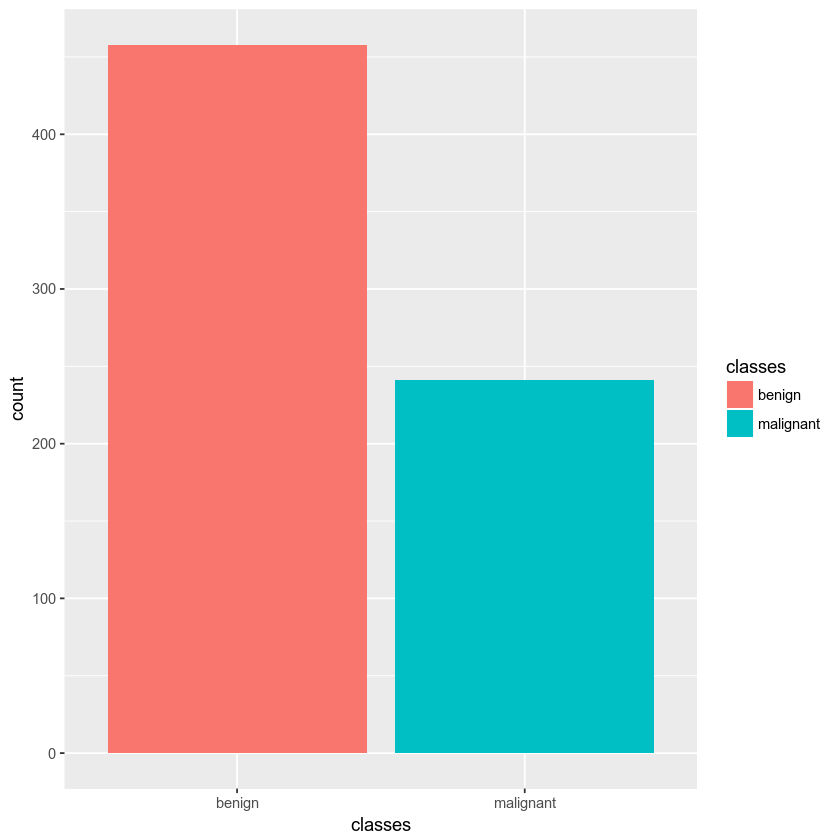

In [8]:
library(ggplot2)

ggplot(bc_data, aes(x = classes, fill = classes)) +
  geom_bar()

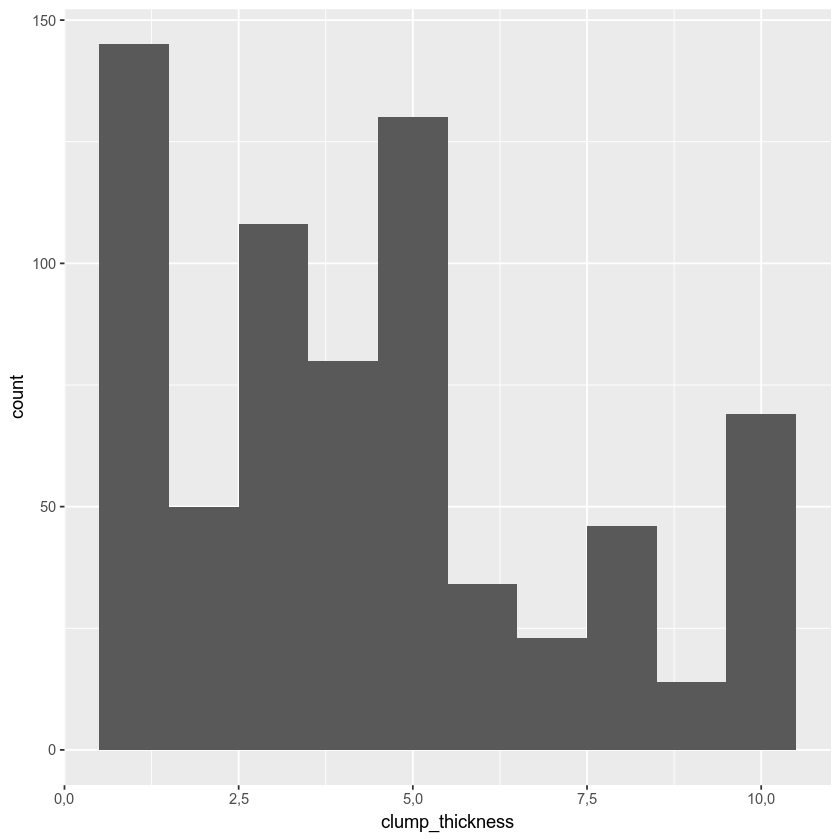

In [9]:
#i'll ignore the unbalance of data, and implement this on other study.
ggplot(bc_data, aes(x = clump_thickness)) +
  geom_histogram(bins = 10)

In [10]:
install.packages(c('ellipse'))
source("https://bioconductor.org/biocLite.R")
biocLite("pcaGoPromoter")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
A new version of Bioconductor is available after installing the most recent
  version of R; see http://bioconductor.org/install
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.3 (2017-11-30).
Installing package(s) ‘pcaGoPromoter’
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'BH', 'bindr', 'bindrcpp', 'broom', 'callr', 'caret',
  'checkpoint', 'clipr', 'cluster', 'Cubist', 'curl', 'CVST', 'data.table',
  'dbplyr', 'ddalpha', 'digest', 'doParallel', 'dplyr', 'DRR', 'earth',
  'ellipse', 'forcats', 'foreach', 'foreign', 'gam', 'ggplot2', 'glmnet',
  'gtools', 'haven', 'hexbin', 'highr', 'hms', 'htmlwidgets', 'httpuv',
  'IRdisplay', 'iterators', 'jsonlite', 'kernlab', 'klaR', 'knitr', 'lava',
  'lme4', 'lubridate', 'maps', 'MASS', 'Matrix', 'mgcv', 'mice', 

Loading required package: ellipse
Loading required package: Biostrings
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min

Loading require

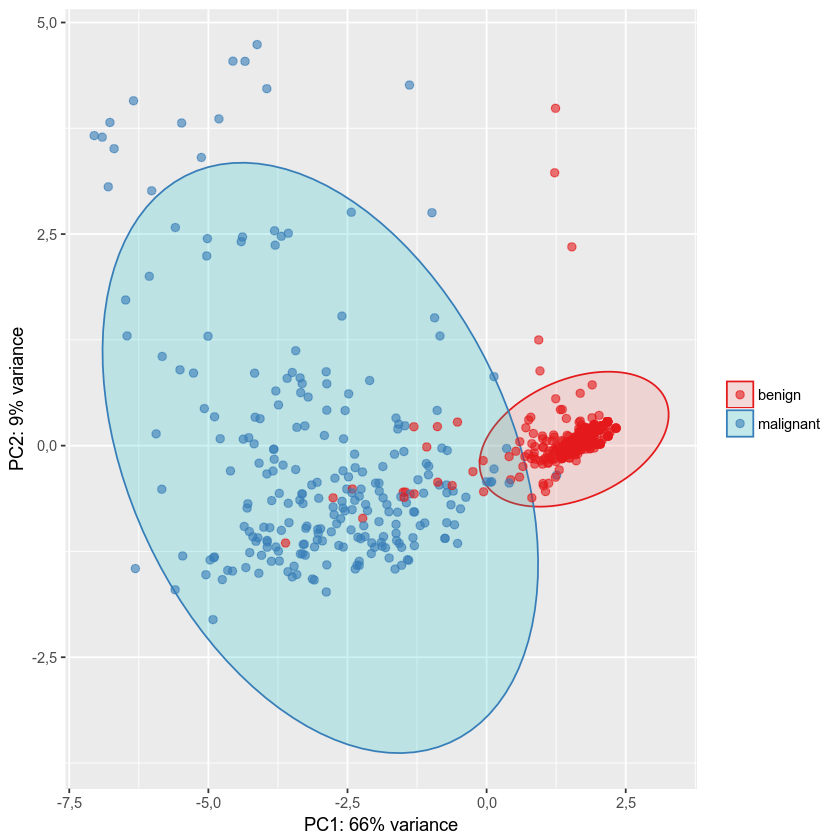

In [11]:
library(pcaGoPromoter)
library(ellipse)

# perform pca and extract scores
pcaOutput <- pca(t(bc_data[, -1]), printDropped = FALSE, scale = TRUE, center = TRUE)
pcaOutput2 <- as.data.frame(pcaOutput$scores)
  
# define groups for plotting
pcaOutput2$groups <- bc_data$classes
  
centroids <- aggregate(cbind(PC1, PC2) ~ groups, pcaOutput2, mean)

conf.rgn  <- do.call(rbind, lapply(unique(pcaOutput2$groups), function(t)
  data.frame(groups = as.character(t),
             ellipse(cov(pcaOutput2[pcaOutput2$groups == t, 1:2]),
                   centre = as.matrix(centroids[centroids$groups == t, 2:3]),
                   level = 0.95),
             stringsAsFactors = FALSE)))
    
ggplot(data = pcaOutput2, aes(x = PC1, y = PC2, group = groups, color = groups)) + 
    geom_polygon(data = conf.rgn, aes(fill = groups), alpha = 0.2) +
    geom_point(size = 2, alpha = 0.6) + 
    scale_color_brewer(palette = "Set1") +
    labs(color = "",
         fill = "",
         x = paste0("PC1: ", round(pcaOutput$pov[1], digits = 2) * 100, "% variance"),
         y = paste0("PC2: ", round(pcaOutput$pov[2], digits = 2) * 100, "% variance")) 


Attaching package: ‘tidyr’

The following object is masked from ‘package:S4Vectors’:

    expand

The following object is masked from ‘package:mice’:

    complete



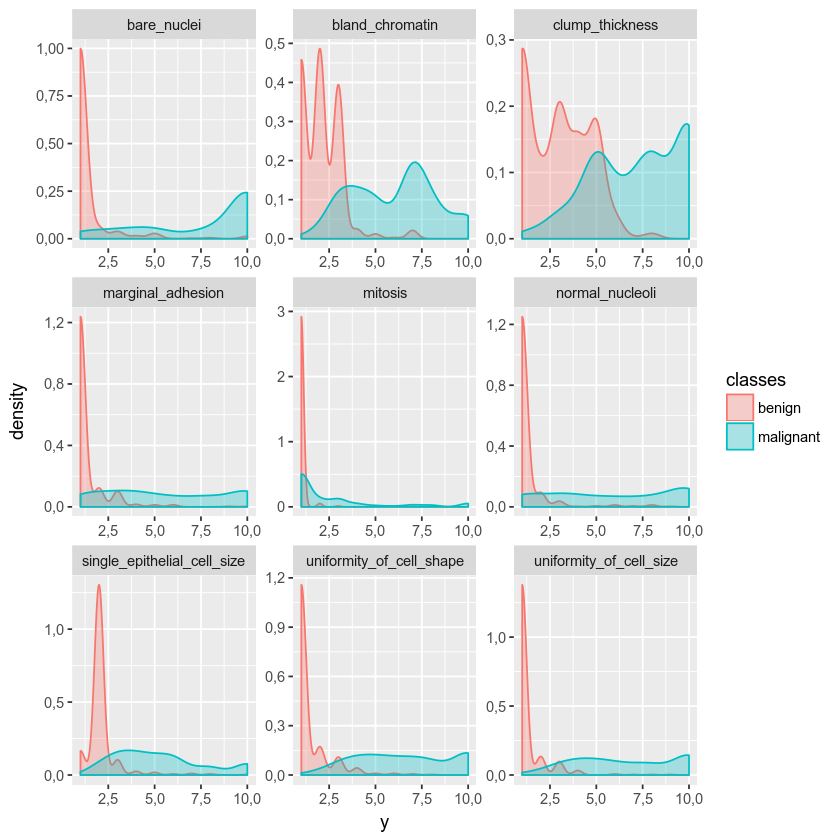

In [12]:
library(tidyr)

gather(bc_data, x, y, clump_thickness:mitosis) %>%
  ggplot(aes(x = y, color = classes, fill = classes)) +
    geom_density(alpha = 0.3) +
    facet_wrap( ~ x, scales = "free", ncol = 3)

In [13]:
# configure multicore
library(doParallel)
cl <- makeCluster(detectCores())
registerDoParallel(cl)

Loading required package: foreach
Loading required package: iterators


In [14]:
library(caret)


In [15]:
set.seed(42)
index <- createDataPartition(bc_data$classes, p = 0.7, list = FALSE)
train_data <- bc_data[index, ]
test_data  <- bc_data[-index, ]


Attaching package: ‘dplyr’

The following objects are masked from ‘package:Biostrings’:

    collapse, intersect, setdiff, setequal, union

The following object is masked from ‘package:XVector’:

    slice

The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union

The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



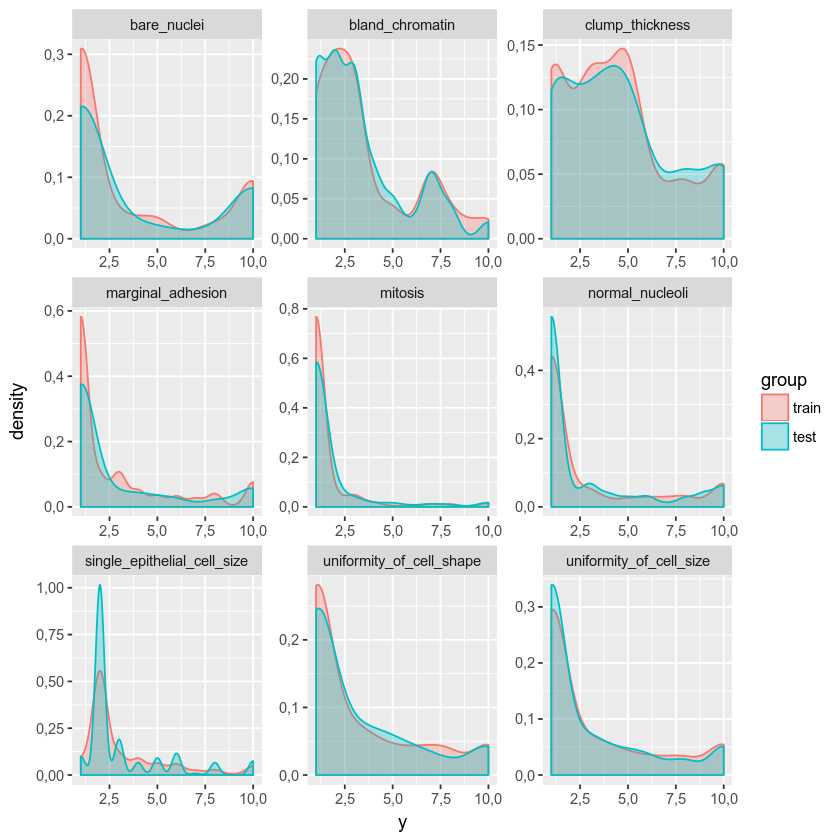

In [16]:
library(dplyr)

rbind(data.frame(group = "train", train_data),
      data.frame(group = "test", test_data)) %>%
  gather(x, y, clump_thickness:mitosis) %>%
  ggplot(aes(x = y, color = group, fill = group)) +
    geom_density(alpha = 0.3) +
    facet_wrap( ~ x, scales = "free", ncol = 3)

In [17]:
set.seed(42)
model_glm <- caret::train(clump_thickness ~ .,
                          data = train_data,
                          method = "glm",
                          preProcess = c("scale", "center"),
                          trControl = trainControl(method = "repeatedcv", 
                                                  number = 10, 
                                                  repeats = 10, 
                                                  savePredictions = TRUE, 
                                                  verboseIter = FALSE))

In [18]:
model_glm

Generalized Linear Model 

490 samples
  9 predictor

Pre-processing: scaled (9), centered (9) 
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 440, 440, 441, 441, 442, 441, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1,977351  0,5024108  1,638775


In [19]:
predictions <- predict(model_glm, test_data)


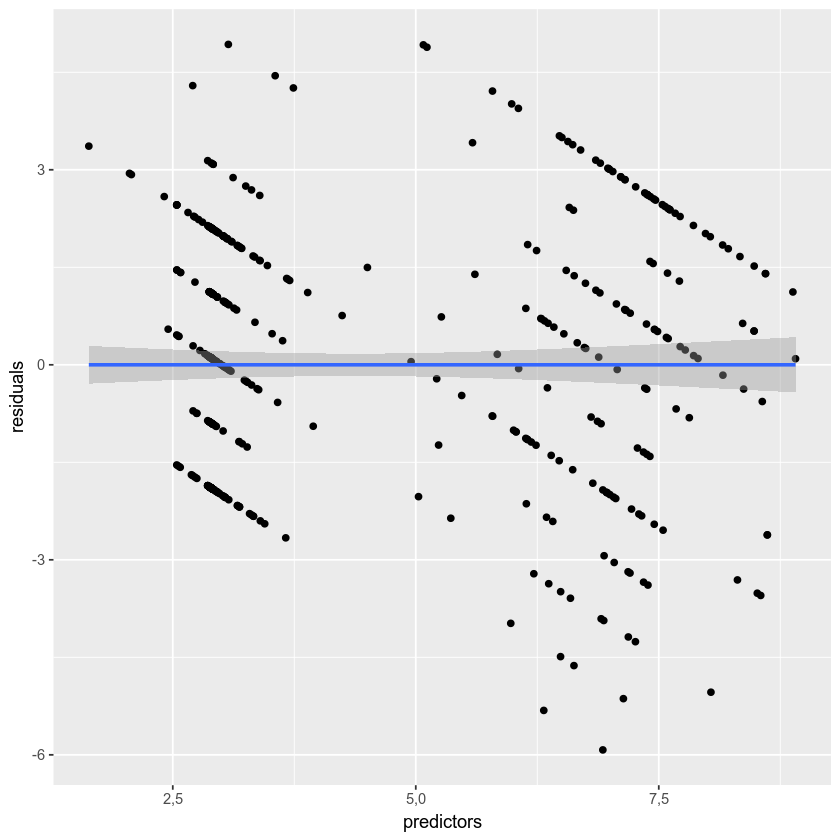

In [20]:
data.frame(residuals = resid(model_glm),
           predictors = model_glm$finalModel$linear.predictors) %>%
  ggplot(aes(x = predictors, y = residuals)) +
    geom_jitter() +
    geom_smooth(method = "lm")

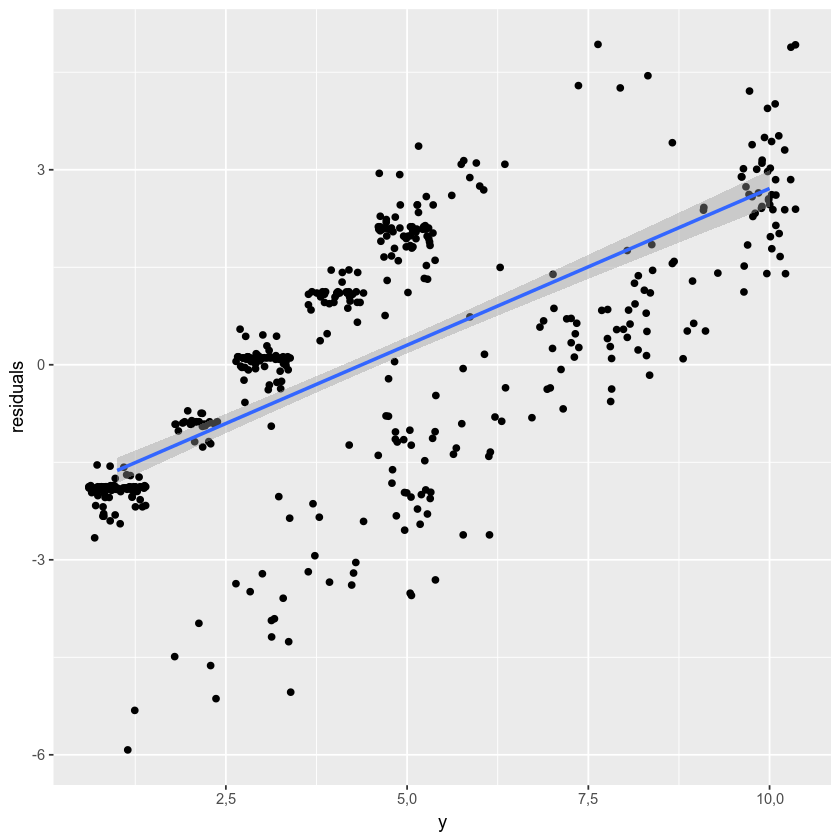

In [21]:
data.frame(residuals = resid(model_glm),
           y = model_glm$finalModel$y) %>%
  ggplot(aes(x = y, y = residuals)) +
    geom_jitter() +
    geom_smooth(method = "lm")

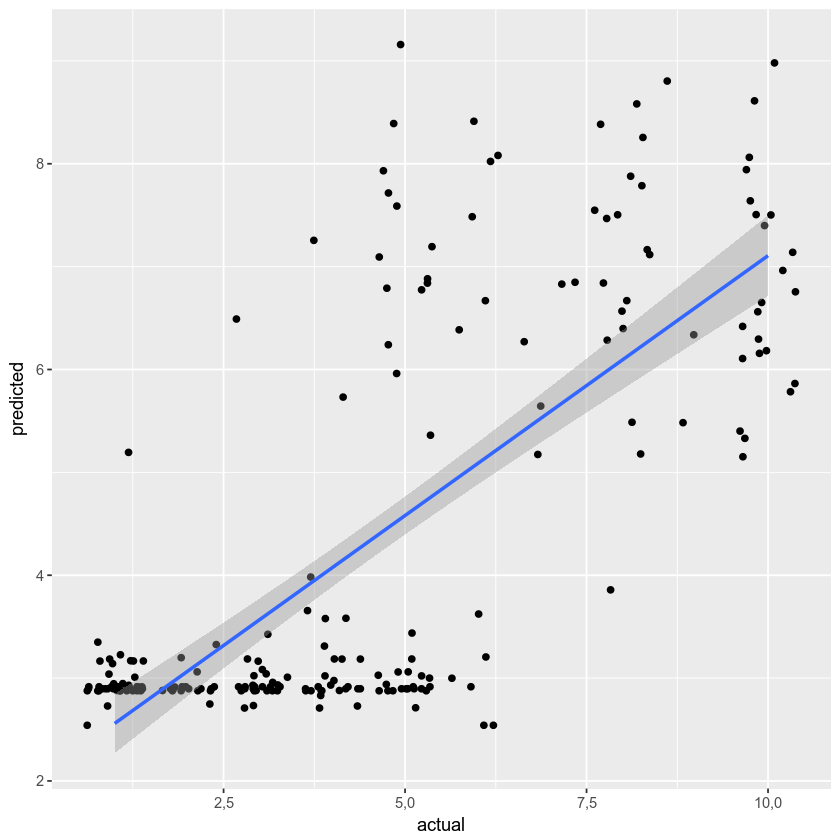

In [22]:
data.frame(actual = test_data$clump_thickness,
           predicted = predictions) %>%
  ggplot(aes(x = actual, y = predicted)) +
    geom_jitter() +
    geom_smooth(method = "lm")

In [23]:
install.packages('rpart.plot')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


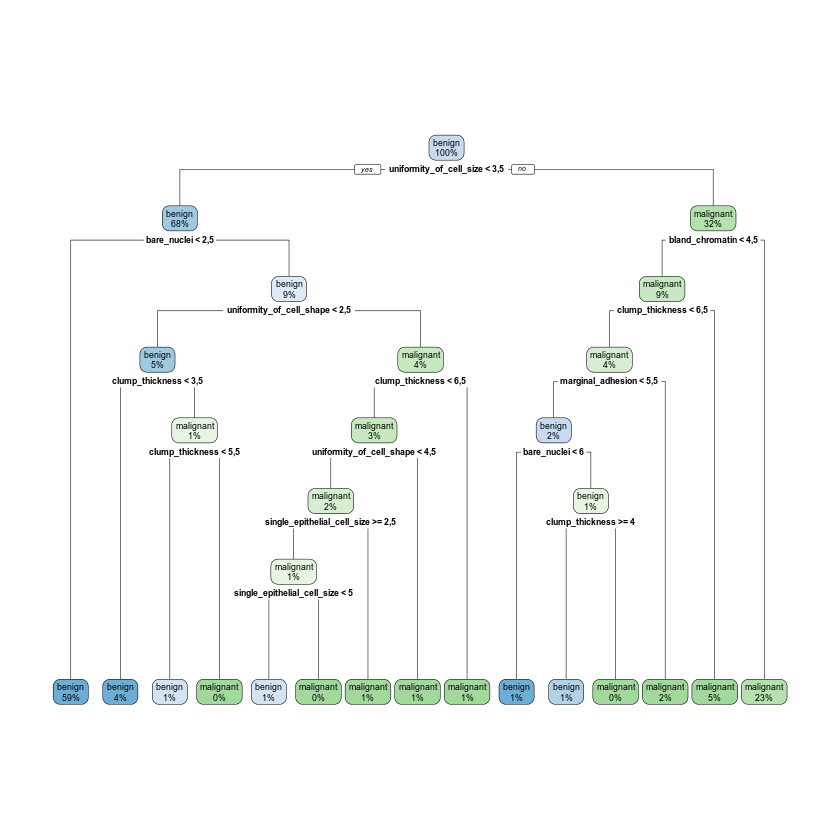

In [24]:
library(rpart)
library(rpart.plot)

set.seed(42)
fit <- rpart(classes ~ .,
            data = train_data,
            method = "class",
            control = rpart.control(xval = 10, 
                                    minbucket = 2, 
                                    cp = 0), 
             parms = list(split = "information"))

rpart.plot(fit, extra = 100)

In [25]:
install.packages('caret', dependencies = TRUE)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [26]:
set.seed(42)
model_rf <- caret::train(classes ~ .,
                         data = train_data,
                         method = "rf",
                         preProcess = c("scale", "center"),
                         trControl = trainControl(method = "repeatedcv", 
                                                  number = 10, 
                                                  repeats = 10, 
                                                  savePredictions = TRUE, 
                                                  verboseIter = FALSE))

In [27]:
model_rf$finalModel$confusion


,benign,malignant,class.error
benign,313,8,"0,02492212"
malignant,5,164,"0,02958580"


In [28]:
imp <- model_rf$finalModel$importance
imp[order(imp, decreasing = TRUE), ]

uniformity_of_cell_size                 bare_nuclei 
                  50,713526                   36,258949 
   uniformity_of_cell_shape             bland_chromatin 
                  34,061993                   28,140743 
single_epithelial_cell_size             normal_nucleoli 
                  22,164888                   17,519498 
            clump_thickness           marginal_adhesion 
                  15,331526                   12,903038 
                    mitosis 
                   3,061314

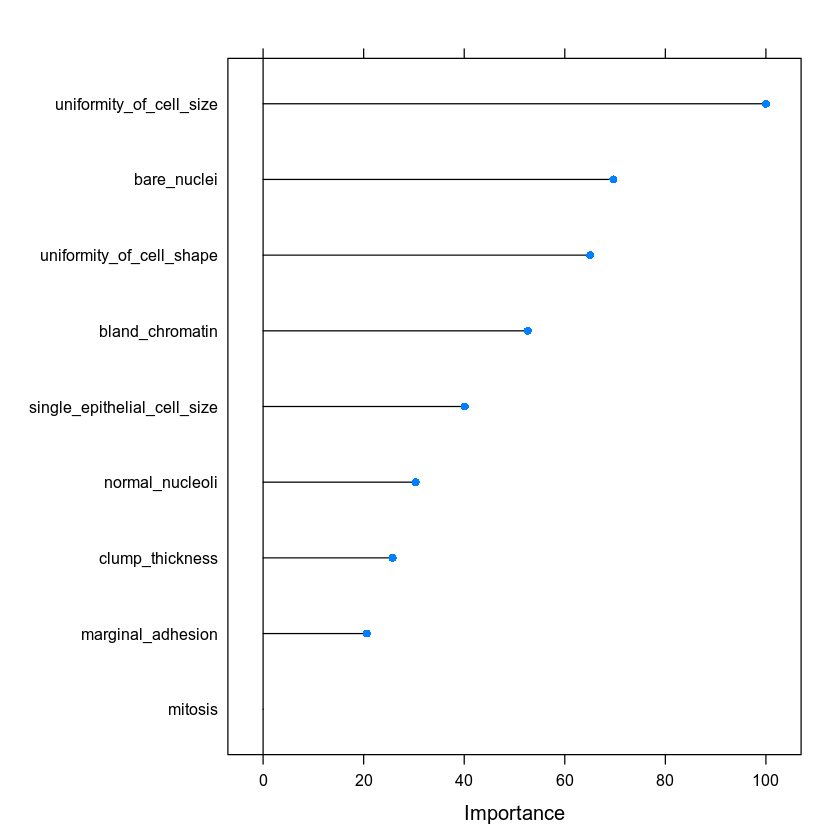

In [29]:
# estimate variable importance
importance <- varImp(model_rf, scale = TRUE)
plot(importance)

In [30]:
confusionMatrix(predict(model_rf, test_data), test_data$classes)


Confusion Matrix and Statistics

           Reference
Prediction  benign malignant
  benign       133         2
  malignant      4        70
                                          
               Accuracy : 0,9713          
                 95% CI : (0,9386, 0,9894)
    No Information Rate : 0,6555          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0,9369          
 Mcnemar's Test P-Value : 0,6831          
                                          
            Sensitivity : 0,9708          
            Specificity : 0,9722          
         Pos Pred Value : 0,9852          
         Neg Pred Value : 0,9459          
             Prevalence : 0,6555          
         Detection Rate : 0,6364          
   Detection Prevalence : 0,6459          
      Balanced Accuracy : 0,9715          
                                          
       'Positive' Class : benign          
                                          

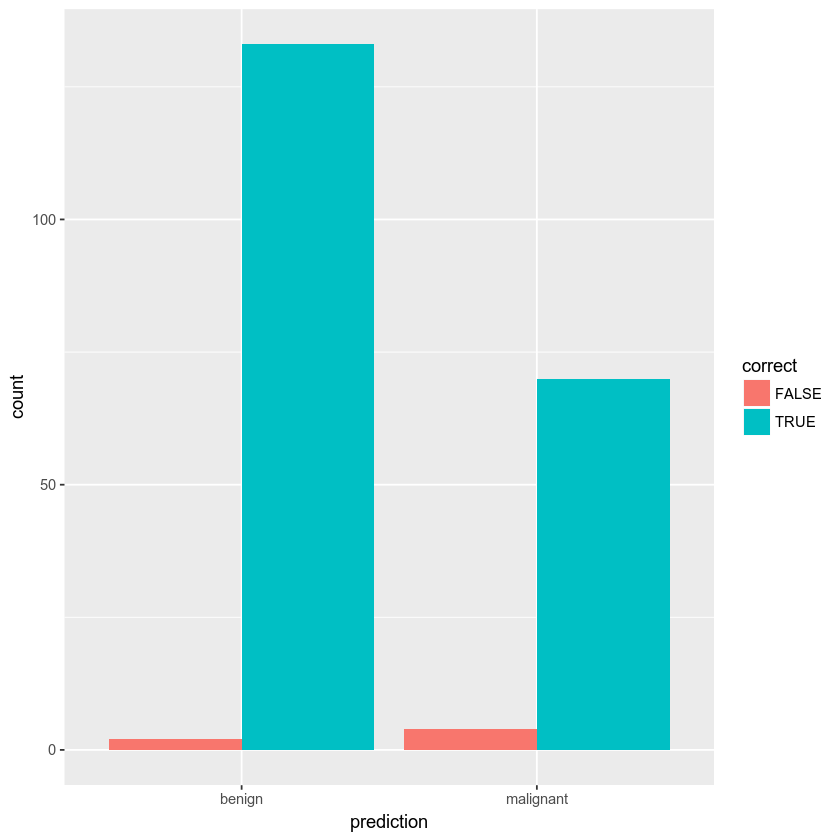

In [31]:
results <- data.frame(actual = test_data$classes,
                      predict(model_rf, test_data, type = "prob"))

results$prediction <- ifelse(results$benign > 0.5, "benign",
                             ifelse(results$malignant > 0.5, "malignant", NA))

results$correct <- ifelse(results$actual == results$prediction, TRUE, FALSE)

ggplot(results, aes(x = prediction, fill = correct)) +
  geom_bar(position = "dodge")

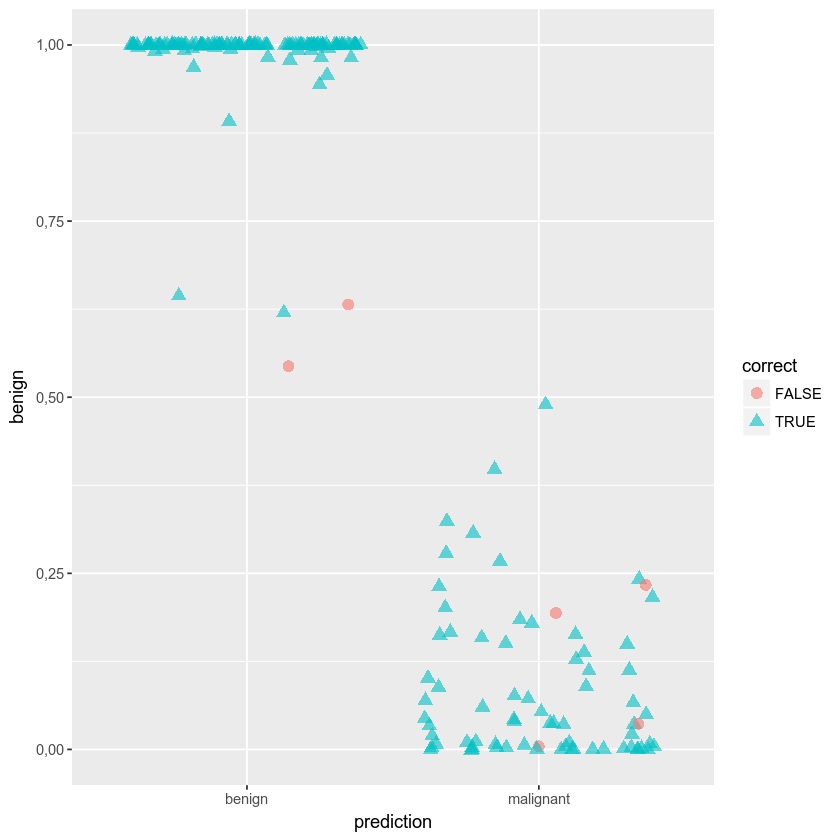

In [32]:
ggplot(results, aes(x = prediction, y = benign, color = correct, shape = correct)) +
  geom_jitter(size = 3, alpha = 0.6)

In [33]:
install.packages('corrplot')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


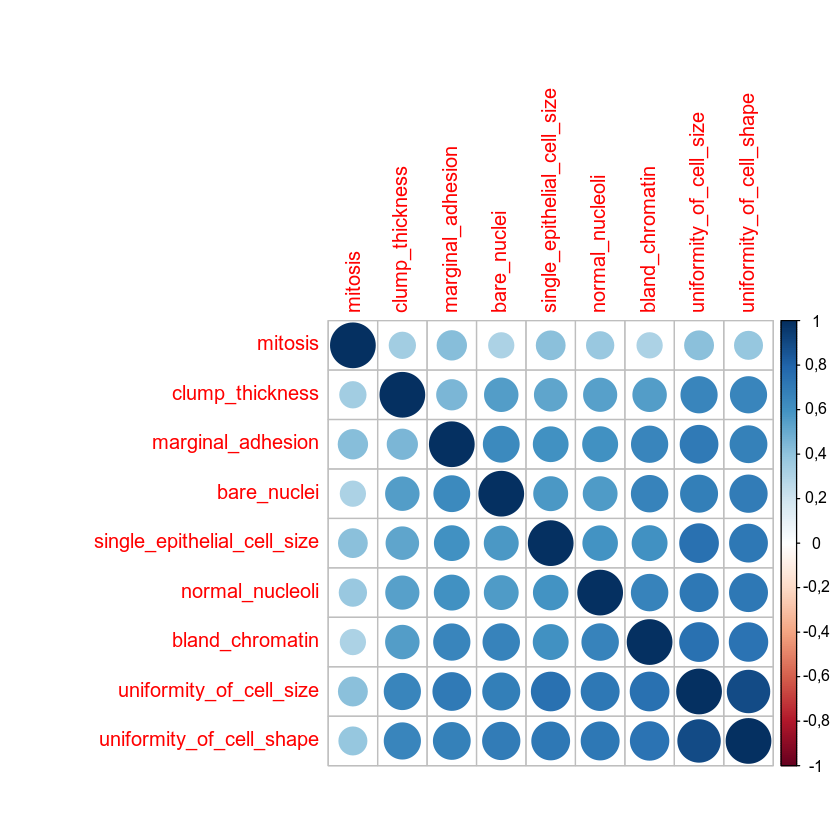

In [34]:
library(corrplot)

# calculate correlation matrix
corMatMy <- cor(train_data[, -1])
corrplot(corMatMy, order = "hclust")

In [35]:
#Apply correlation filter at 0.70,
highlyCor <- colnames(train_data[, -1])[findCorrelation(corMatMy, cutoff = 0.7, verbose = TRUE)]

Compare row 2  and column  3 with corr  0,899 
  Means:  0,696 vs 0,575 so flagging column 2 
Compare row 3  and column  7 with corr  0,736 
  Means:  0,653 vs 0,55 so flagging column 3 
All correlations <= 0,7 


In [36]:
# which variables are flagged for removal?
highlyCor

[1] "uniformity_of_cell_size"  "uniformity_of_cell_shape"

In [37]:
train_data_cor <- train_data[, which(!colnames(train_data) %in% highlyCor)]

In [38]:
set.seed(7)
results_rfe <- rfe(x = train_data[, -1], 
                   y = train_data$classes, 
                   sizes = c(1:9), 
                   rfeControl = rfeControl(functions = rfFuncs, method = "cv", number = 10))

In [39]:
# chosen features
predictors(results_rfe)

[1] "bare_nuclei"                 "uniformity_of_cell_size"    
[3] "clump_thickness"             "uniformity_of_cell_shape"   
[5] "bland_chromatin"             "marginal_adhesion"          
[7] "normal_nucleoli"             "single_epithelial_cell_size"

In [40]:
train_data_rfe <- train_data[, c(1, which(colnames(train_data) %in% predictors(results_rfe)))]


In [41]:
set.seed(27)
model_ga <- gafs(x = train_data[, -1], 
                 y = train_data$classes,
                 iters = 10, # generations of algorithm
                 popSize = 10, # population size for each generation
                 levels = c("malignant", "benign"),
                 gafsControl = gafsControl(functions = rfGA, # Assess fitness with RF
                                           method = "cv",    # 10 fold cross validation
                                           genParallel = TRUE, # Use parallel programming
                                           allowParallel = TRUE))

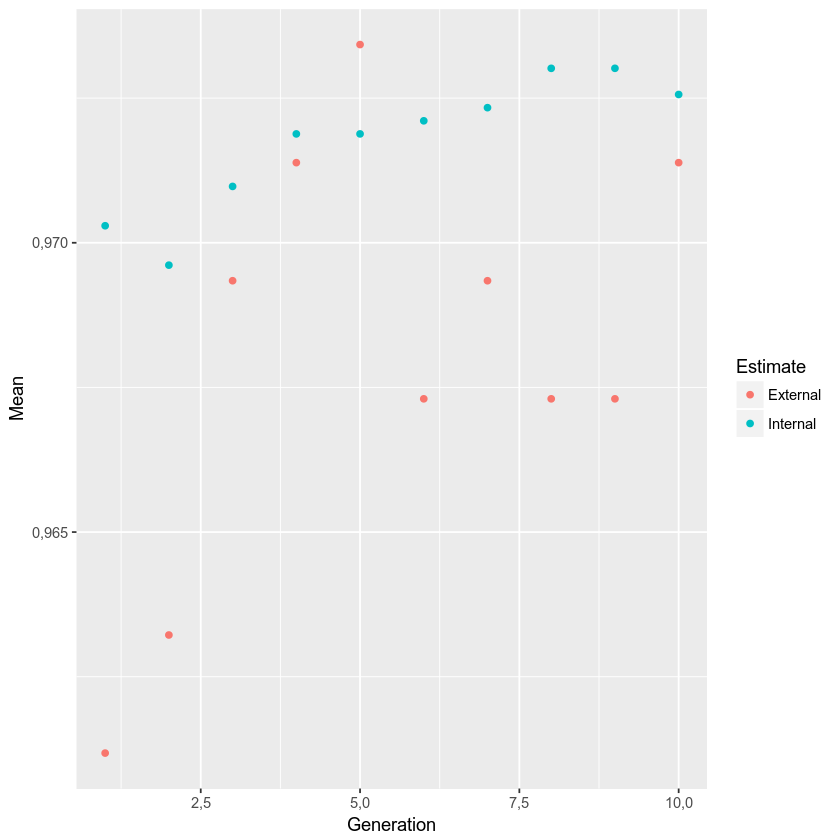

In [42]:
plot(model_ga) # Plot mean fitness (AUC) by generation

In [43]:
train_data_ga <- train_data[, c(1, which(colnames(train_data) %in% model_ga$ga$final))]